Diederik P. Kingma, "Auto-Encoding Variational Bayes", ICLR, 2013
(https://arxiv.org/abs/1312.6114)

In [32]:
import time
import torch
from torch import nn, cuda, device, optim, utils, randn, exp
from torch.autograd import Variable
import torchvision as tv
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import torch.nn.functional as F

print(cuda.is_available())
device = device('cuda:0')
print(device)

True
cuda:0


In [33]:
class Encoder(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()

        self.linear = nn.Linear(image_size, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        a = self.linear(x)
        y = F.relu(a)
        mu, var = self.mu(y), self.var(y)
        return mu, var

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, image_size):
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.rec = nn.Linear(hidden_dim, image_size)
        self.sigm = nn.Sigmoid()

    def forward(self, z):
        y = F.relu(self.linear(z))
        rec = self.sigm(self.rec(y))
        return rec

In [34]:
# Moved to VAETrainer
class VAE(nn.Module):
    def __init__(self, image_size=784, hidden_dim=400, z_dim=20):
        super().__init__()

        self.__dict__.update(locals())

        self.encoder = Encoder(image_size=image_size, 
                               hidden_dim=hidden_dim, 
                               z_dim=z_dim).to(device)
        self.decoder = Decoder(z_dim=z_dim,
                               hidden_dim=hidden_dim,
                               image_size=image_size).to(device)

        self.shape = int(image_size ** 0.5)

    def forward(self, x):
        mu, var = self.encoder(x)
        z = self.reparameterize(mu, var)
        rec = self.decoder(z)
        return rec, mu, var

    def reparameterize(self, mu, log_var):
        #Reparametrization trick: z = mean + std*epsilon, where epsilon ~ N(0, 1).
        epsilon = to_cuda(torch.randn(mu.shape))
        z = mu + epsilon * torch.exp(log_var/2) # 2 for convert var to std
        return z

In [35]:
#model = VAE(image_size=image_size, hidden_dim=hidden_dim, z_dim=z_dim)

In [40]:
image_size = 28
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean=(0.5,), std=(0.5,))])
dataset = datasets.MNIST(root="/raid/artem/tmp", train=True, transform=tfms, download=True)

In [41]:
#batch_size = 128
#image_size = 64
#dataroot = '/raid/artem/tmp/celeba/'
#transform = transforms.Compose([transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#dataset = datasets.ImageFolder(root=dataroot, transform = transform)
dataloader = utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, drop_last=True)
print(len(dataloader))

1666


In [42]:
class VAETrainer:
    def __init__(self, encoder, decoder, dataloader, optimizer, criterion, epochs, device):
        self.device = device
        self.E = encoder.to(self.device)
        self.D = decoder.to(self.device)
        self.dataloader = dataloader
        self.rec_criterion = criterion
        self.epochs = epochs
        self.E_losses = []
        self.D_losses = []
    
    def train(self):
        for epoch in range(1, self.epochs + 1):
            start = time.time()

            for idx, (data, _) in enumerate(self.dataloader):
                #if idx == 500: break
                optimizer.zero_grad()

                x = Variable(data.view(batch_size, -1)).to(self.device)
                mu, var = self.E(x)
                # Reparametrization trick: z = mean + std * epsilon, where epsilon ~ N(0, 1).
                epsilon = Variable(torch.randn(mu.shape).to(self.device))
                z = mu + epsilon * torch.exp(var/2)
                rec = self.D(z)

                rec_loss = self.rec_criterion(x, rec)
                #div_loss = div_criterion(mu, var)
                div_loss = torch.sum(0.5 * (mu**2 + torch.exp(var) - var - 1))
                
                loss = rec_loss + div_loss
                loss.backward()
                optimizer.step()

                self.D_losses.append(rec_loss.item())
                self.E_losses.append(div_loss.item())

                if not (idx % 1000):
                    print('[%d/%d;%d/%d]: loss_d: %.3f, loss_g: %.3f'
                      % (idx, len(dataloader),
                         (epoch), self.epochs, 
                         torch.mean(torch.FloatTensor(self.D_losses)), 
                         torch.mean(torch.FloatTensor(self.E_losses))))

In [43]:
lr = 1e-3
wd = 1e-5

z_dim = 20
hidden_dim = 400
size = 28*28
batch_size = 36

dataloader = utils.data.DataLoader(dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=8, drop_last=True)
E = Encoder(image_size=size, hidden_dim=hidden_dim, z_dim=z_dim)
D = Decoder(z_dim=z_dim, hidden_dim=hidden_dim, image_size=size)

parameters = list(E.parameters()) + list(D.parameters())
optimizer = optim.Adam(params=[p for p in parameters if p.requires_grad], lr=lr, weight_decay=wd)

rec_criterion = torch.nn.MSELoss(reduction='sum')
div_criterion = torch.nn.KLDivLoss(reduction='sum')

trainer = VAETrainer(encoder=E, decoder=D, dataloader=dataloader, optimizer=optimizer,
                     criterion=rec_criterion, epochs=25, device=device)

trainer.train()


[0/1666;1/25]: loss_d: 54643.223, loss_g: 23.704
[1000/1666;1/25]: loss_d: 26263.617, loss_g: 171.196
[0/1666;2/25]: loss_d: 26104.570, loss_g: 144.814
[1000/1666;2/25]: loss_d: 25925.443, loss_g: 163.104
[0/1666;3/25]: loss_d: 25834.324, loss_g: 181.854
[1000/1666;3/25]: loss_d: 25721.783, loss_g: 209.431
[0/1666;4/25]: loss_d: 25660.861, loss_g: 225.879
[1000/1666;4/25]: loss_d: 25581.637, loss_g: 247.678
[0/1666;5/25]: loss_d: 25536.824, loss_g: 260.635
[1000/1666;5/25]: loss_d: 25477.691, loss_g: 277.512
[0/1666;6/25]: loss_d: 25444.273, loss_g: 287.248
[1000/1666;6/25]: loss_d: 25399.424, loss_g: 300.330
[0/1666;7/25]: loss_d: 25373.430, loss_g: 307.923
[1000/1666;7/25]: loss_d: 25338.629, loss_g: 318.168
[0/1666;8/25]: loss_d: 25318.033, loss_g: 324.372
[1000/1666;8/25]: loss_d: 25289.965, loss_g: 332.787
[0/1666;9/25]: loss_d: 25272.863, loss_g: 337.928
[1000/1666;9/25]: loss_d: 25249.832, loss_g: 344.988
[0/1666;10/25]: loss_d: 25235.520, loss_g: 349.317
[1000/1666;10/25]: loss

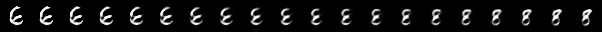

In [48]:
import numpy as np
from PIL import Image

z1 = torch.normal(torch.zeros(z_dim), 1)
z2 = torch.normal(torch.zeros(z_dim), 1)

images = []
for alpha in np.linspace(0, 1, z_dim):
    z = alpha*z1 + (1-alpha)*z2
    y = D(z.to(device))
    y_img = y.view((28,28))[None,:,:]
    images.append(y_img)

batch = torch.stack(images).detach().cpu()
to_img = tv.transforms.ToPILImage()
display(to_img(tv.utils.make_grid(batch, nrow=z_dim)))
#plt.imshow(to_img(tv.utils.make_grid(batch))),plt.show()

Train VAE with laten vector size 2 to visualize the results

In [52]:
lr = 1e-3
wd = 1e-5

z_dim = 2
hidden_dim = 400
size = 28*28

E = Encoder(image_size=size, hidden_dim=hidden_dim, z_dim=z_dim)
D = Decoder(z_dim=z_dim, hidden_dim=hidden_dim, image_size=size)

parameters = list(E.parameters()) + list(D.parameters())
parameters = [p for p in parameters if p.requires_grad]
optimizer = optim.Adam(params=parameters, lr=lr, weight_decay=wd)

rec_criterion = torch.nn.MSELoss(reduction='sum')
div_criterion = torch.nn.KLDivLoss(reduction='sum')

trainer = VAETrainer(encoder=E, decoder=D, dataloader=dataloader, optimizer=optimizer,
                     criterion=rec_criterion, epochs=25, device=device)

trainer.train()

[0/1666;1/25]: loss_d: 54777.676, loss_g: 1.760
[1000/1666;1/25]: loss_d: 26120.857, loss_g: 180.867
[0/1666;2/25]: loss_d: 26002.729, loss_g: 152.375
[1000/1666;2/25]: loss_d: 25910.836, loss_g: 134.588
[0/1666;3/25]: loss_d: 25876.055, loss_g: 129.061
[1000/1666;3/25]: loss_d: 25840.162, loss_g: 124.690
[0/1666;4/25]: loss_d: 25823.059, loss_g: 122.942
[1000/1666;4/25]: loss_d: 25803.447, loss_g: 121.262
[0/1666;5/25]: loss_d: 25792.986, loss_g: 120.429
[1000/1666;5/25]: loss_d: 25780.801, loss_g: 119.614
[0/1666;6/25]: loss_d: 25773.457, loss_g: 119.335
[1000/1666;6/25]: loss_d: 25764.621, loss_g: 118.992
[0/1666;7/25]: loss_d: 25758.988, loss_g: 118.916
[1000/1666;7/25]: loss_d: 25751.939, loss_g: 118.837
[0/1666;8/25]: loss_d: 25747.521, loss_g: 118.906
[1000/1666;8/25]: loss_d: 25741.605, loss_g: 119.028
[0/1666;9/25]: loss_d: 25737.719, loss_g: 119.169
[1000/1666;9/25]: loss_d: 25732.400, loss_g: 119.413
[0/1666;10/25]: loss_d: 25729.619, loss_g: 119.515
[1000/1666;10/25]: loss_

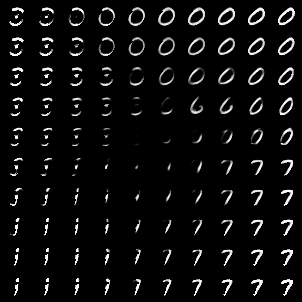

In [53]:
mu = torch.stack([torch.FloatTensor([m1, m2]) 
                  for m1 in np.linspace(-3, 3, 10)
                  for m2 in np.linspace(-3, 3, 10)])
y = D(mu.to(device)).detach().cpu()
to_img = tv.transforms.ToPILImage()
display(to_img(tv.utils.make_grid(y.data.view(mu.shape[0], -1, 28, 28), nrow=10)))

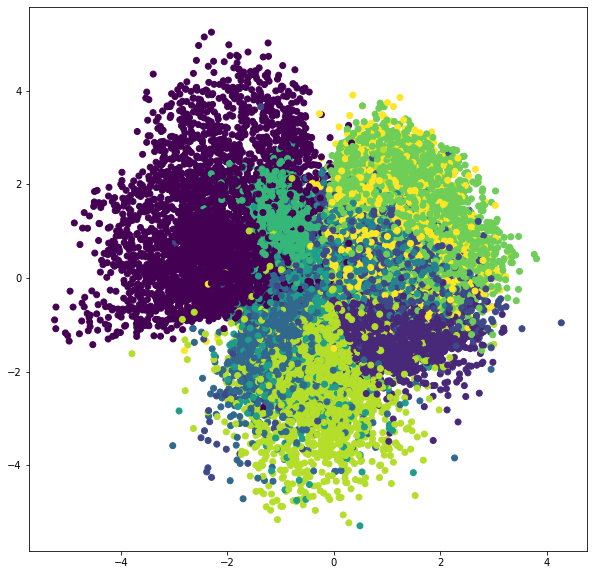

In [54]:
lst = []
dataloader = utils.data.DataLoader(dataset, batch_size=1)

for idx, (data, labels) in enumerate(dataloader):
    #if idx == 8000: break

    x = Variable(data.view(1, -1)).to(device)
    mu, var = E(x)
    lst.append((mu[0][0].item(), mu[0][1].item(), labels.item()))
plt.figure(figsize=(10,10))
plt.scatter([i[0] for i in lst], [i[1] for i in lst], c=[i[2] for i in lst])